## Install Libraries

In [ ]:
!pip install -q ezyquant
!pip install -q quantstats # for visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.9 MB/s eta 0:00:00


## Import libraries

In [ ]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# google authen
from google.colab import drive

drive.mount("/content/drive")

# connect DB
database_path = "/content/drive/MyDrive/DB/ezyquant.db"
ez.connect_sqlite(database_path)

Mounted at /content/drive


In [ ]:
start_data = "2008-01-01"  # import data
start_date = "2010-01-01"  # backtest and report
end_date = _SETDataReaderCached().last_update()

# SET

In [ ]:
UNIVERSE = ["SET"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Screening Conditions

- HHV(5) < HHV(20)
- SMAV(20) > SMAV(90)

Ranking: highest top 10 stock with close price > sma20 


In [ ]:
MODEL_NAME = "Steady Upward Price Trend"

close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")
high_df = ssc.get_data(field="close", timeframe="daily")
low_df = ssc.get_data(field="close", timeframe="daily")

# donchian
dc_5_high, dc_5_low, dc_5_mid, dc_5_prc, dc_5_width = ssc.ta.dc(
    high=high_df, low=low_df, close=close_df, window=5
)
dc_20_high, dc_20_low, dc_20_mid, dc_20_prc, dc_20_width = ssc.ta.dc(
    high=high_df, low=low_df, close=close_df, window=20
)

# sma
sma_20_df = ssc.ta.sma(close_df, 20)
sma_90_df = ssc.ta.sma(close_df, 90)

In [ ]:
# screening condition
dc_cond = dc_5_high < dc_20_high
sma_cond = sma_20_df > sma_90_df
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = dc_cond & sma_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
# replace values that signal == True
upward_price_df = pd.DataFrame(
    np.where((signal_df == True), (close_df / sma_20_df), np.nan),
    columns=signal_df.columns,
    index=signal_df.index,
)

# ranking upward_price_df
# 10 upward price
pos_num = 10
signal_trade = ssc.rank(factor_df=upward_price_df, quantity=pos_num, ascending=False)

In [ ]:
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)

## Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

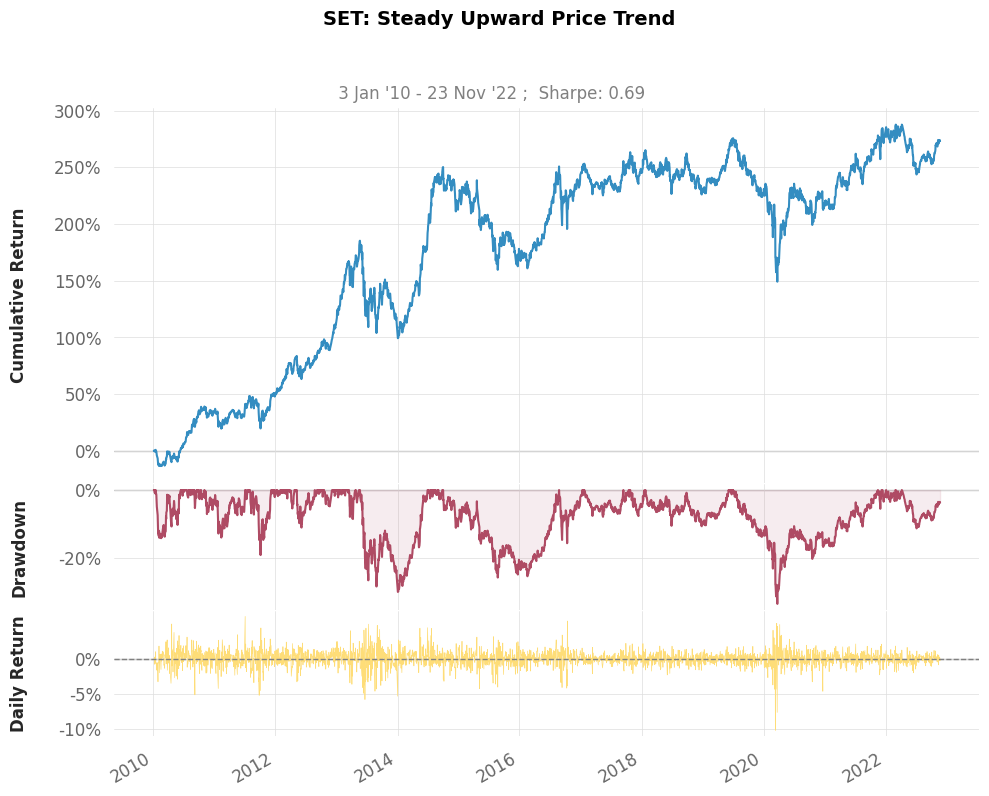

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   273.16%     121.83%
CAGR﹪              10.75%      6.37%

Sharpe              0.69        0.47
Prob. Sharpe Ratio  99.19%      95.09%
Sortino             0.97        0.65
Sortino/√2          0.69        0.46
Omega               1.13        1.13

Max Drawdown        -33.68%     -44.29%
Longest DD Days     866         1763

Gain/Pain Ratio     0.13        0.09
Gain/Pain (1M)      0.68        0.44

Payoff Ratio        0.94        0.89
Profit Factor       1.13        1.09
Common Sense Ratio  1.17        1.06
CPC Index           0.57        0.52
Tail Ratio          1.03        0.97
Outlier Win Ratio   3.58        4.1
Outlier Loss Ratio  3.91        4.26

MTD                 0.74%       0.97%
3M          

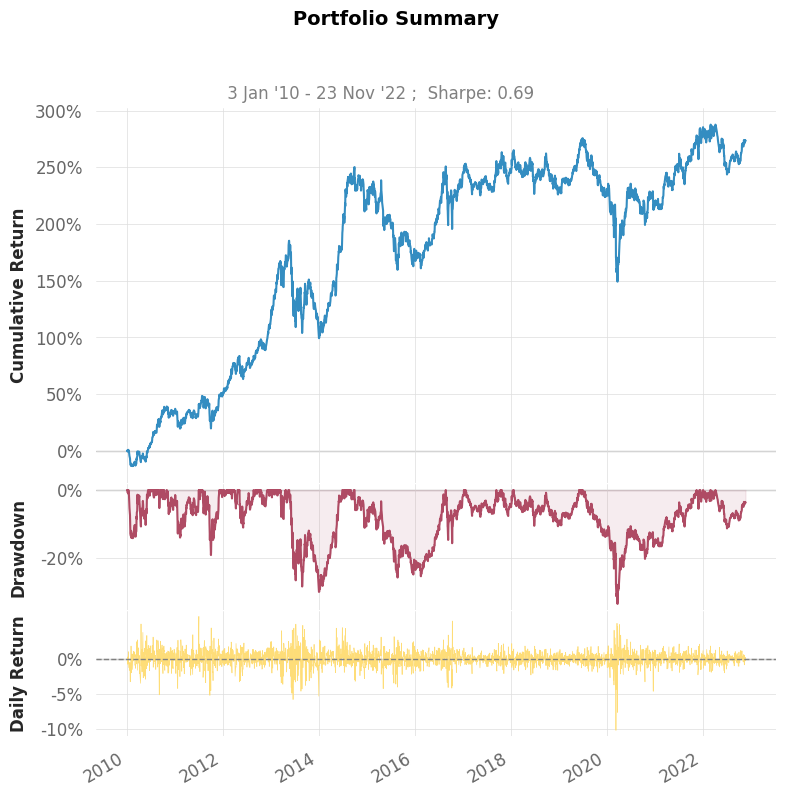

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


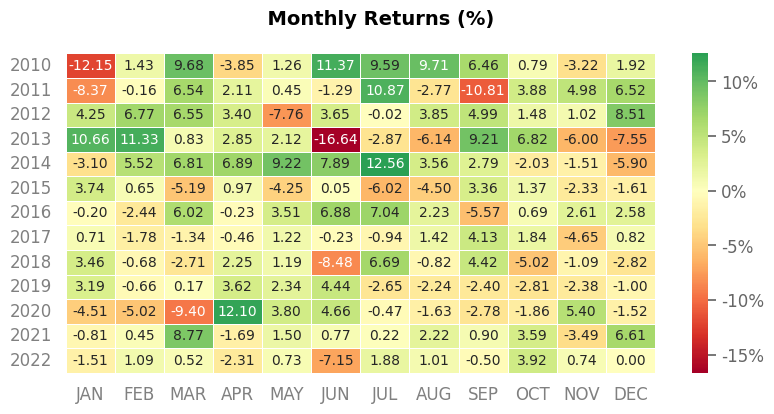

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET100

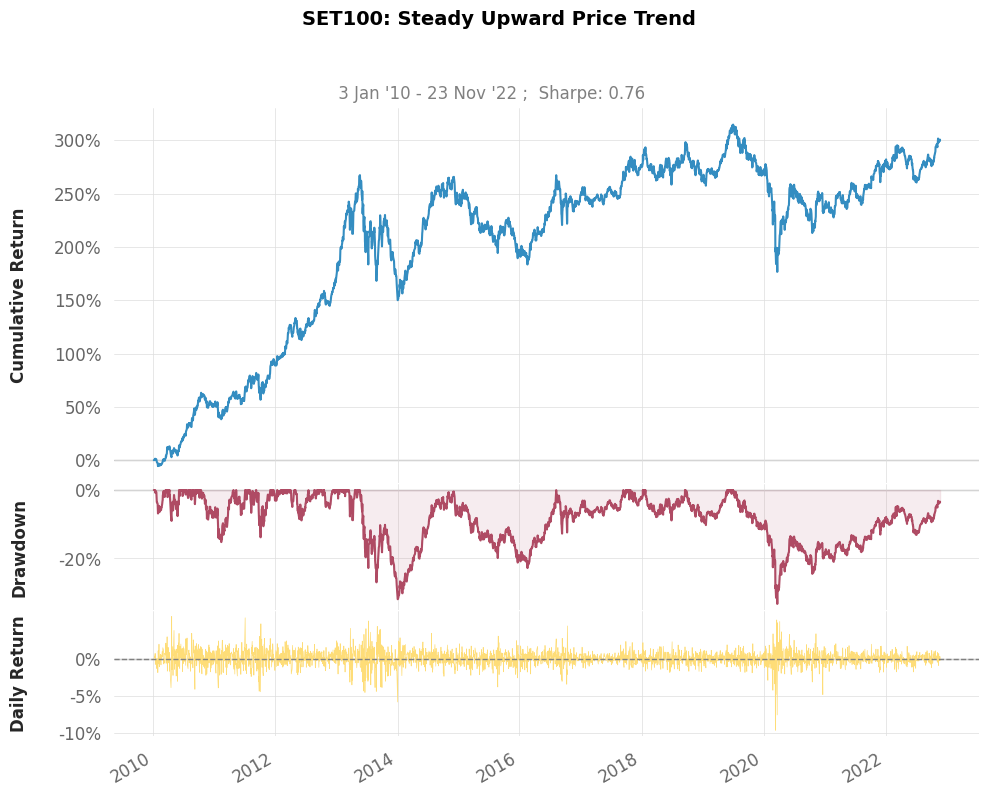

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   300.45%     121.83%
CAGR﹪              11.36%      6.37%

Sharpe              0.76        0.47
Prob. Sharpe Ratio  99.6%       95.09%
Sortino             1.08        0.65
Sortino/√2          0.76        0.46
Omega               1.15        1.15

Max Drawdown        -33.3%      -44.29%
Longest DD Days     1576        1763

Gain/Pain Ratio     0.15        0.09
Gain/Pain (1M)      0.8         0.44

Payoff Ratio        0.97        0.91
Profit Factor       1.15        1.09
Common Sense Ratio  1.2         1.06
CPC Index           0.59        0.53
Tail Ratio          1.05        0.97
Outlier Win Ratio   3.55        3.88
Outlier Loss Ratio  4.01        4.07

MTD                 1.39%       0.97%
3M         

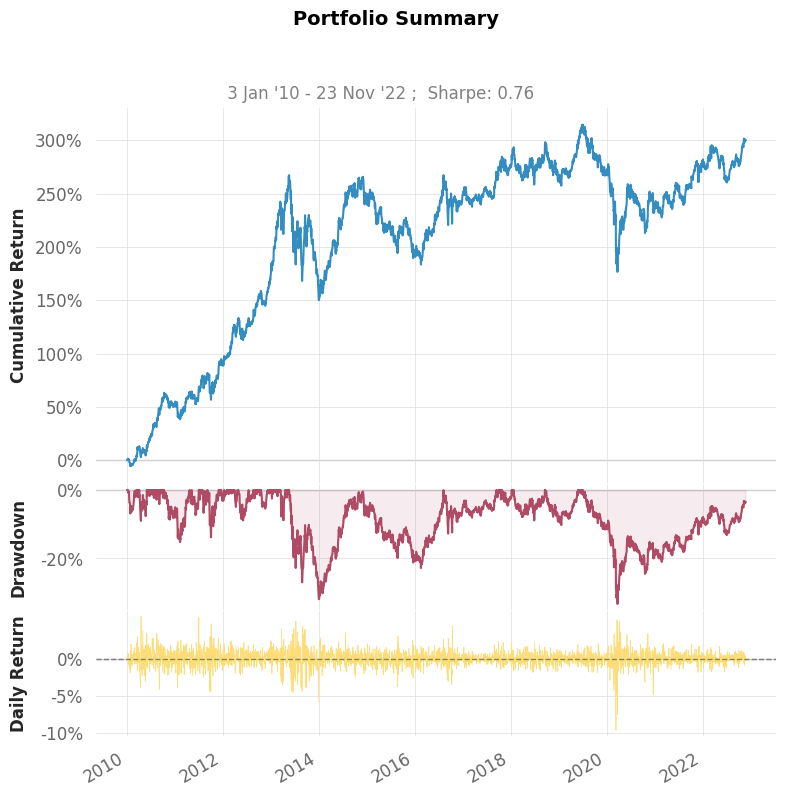

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


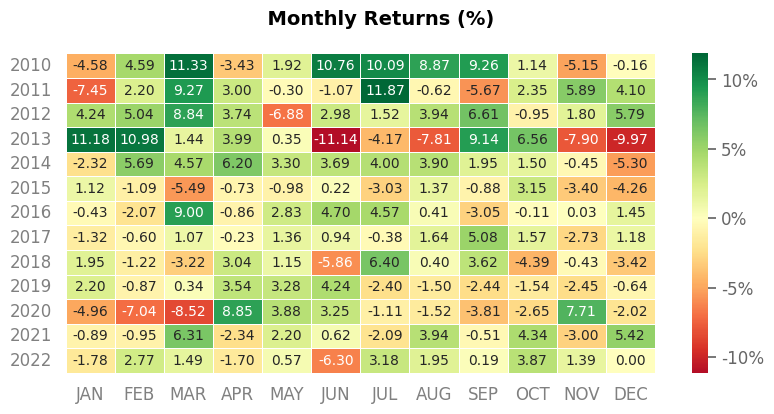

In [ ]:
UNIVERSE = ["SET100"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
## Screening Conditions
MODEL_NAME = "Steady Upward Price Trend"

close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")
high_df = ssc.get_data(field="close", timeframe="daily")
low_df = ssc.get_data(field="close", timeframe="daily")

# donchian
dc_5_high, dc_5_low, dc_5_mid, dc_5_prc, dc_5_width = ssc.ta.dc(
    high=high_df, low=low_df, close=close_df, window=5
)
dc_20_high, dc_20_low, dc_20_mid, dc_20_prc, dc_20_width = ssc.ta.dc(
    high=high_df, low=low_df, close=close_df, window=20
)

# sma
sma_20_df = ssc.ta.sma(close_df, 20)
sma_90_df = ssc.ta.sma(close_df, 90)
# screening condition
dc_cond = dc_5_high < dc_20_high
sma_cond = sma_20_df > sma_90_df
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = dc_cond & sma_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
upward_price_df = pd.DataFrame(
    np.where((signal_df == True), (close_df / sma_20_df), np.nan),
    columns=signal_df.columns,
    index=signal_df.index,
)

# ranking upward_price_df
# 10 upward price
pos_num = 10
signal_trade = ssc.rank(factor_df=upward_price_df, quantity=pos_num, ascending=False)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET50

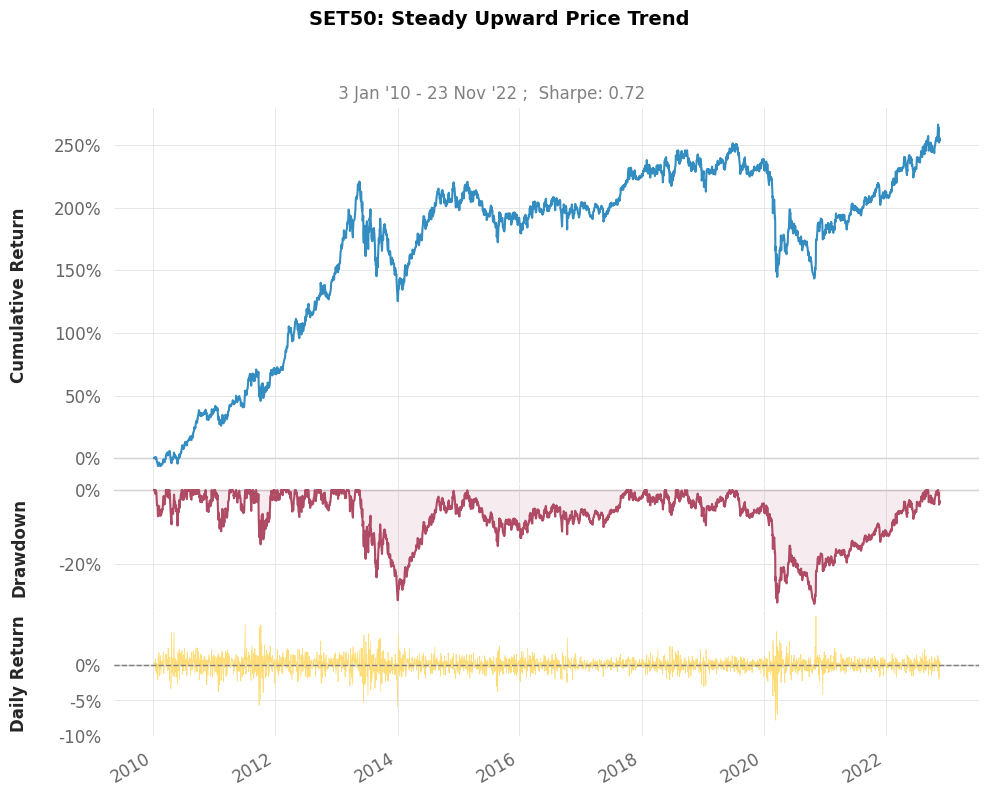

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   255.23%     121.83%
CAGR﹪              10.33%      6.37%

Sharpe              0.72        0.47
Prob. Sharpe Ratio  99.4%       95.09%
Sortino             1.02        0.65
Sortino/√2          0.72        0.46
Omega               1.14        1.14

Max Drawdown        -30.74%     -44.29%
Longest DD Days     1596        1763

Gain/Pain Ratio     0.14        0.09
Gain/Pain (1M)      0.83        0.44

Payoff Ratio        0.95        0.91
Profit Factor       1.14        1.09
Common Sense Ratio  1.17        1.06
CPC Index           0.58        0.54
Tail Ratio          1.03        0.97
Outlier Win Ratio   3.58        3.76
Outlier Loss Ratio  3.87        3.87

MTD                 0.63%       0.97%
3M         

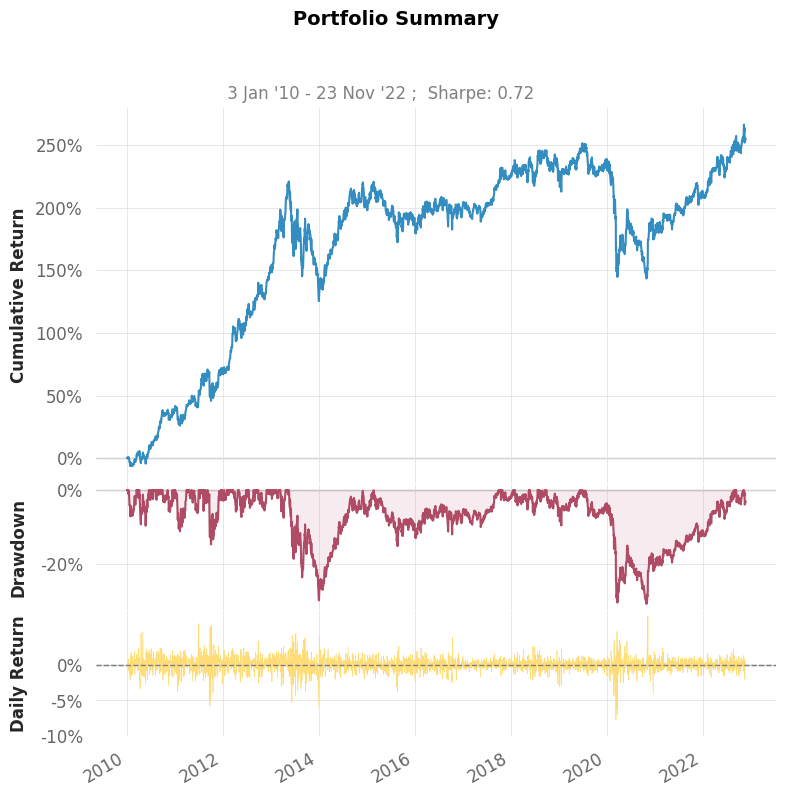

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


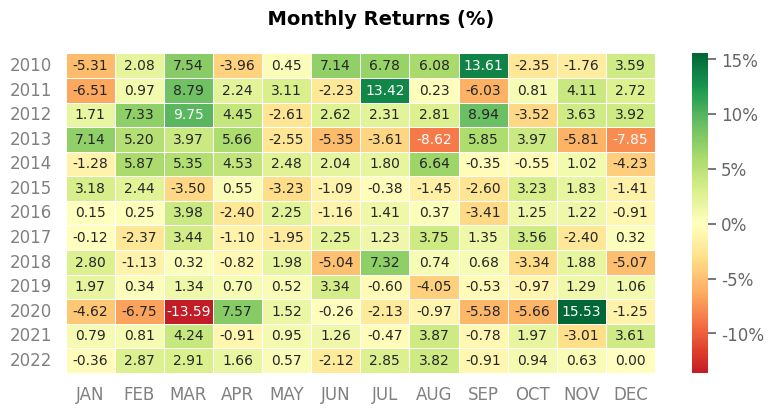

In [ ]:
UNIVERSE = ["SET50"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
## Screening Conditions
MODEL_NAME = "Steady Upward Price Trend"

close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")
high_df = ssc.get_data(field="close", timeframe="daily")
low_df = ssc.get_data(field="close", timeframe="daily")

# donchian
dc_5_high, dc_5_low, dc_5_mid, dc_5_prc, dc_5_width = ssc.ta.dc(
    high=high_df, low=low_df, close=close_df, window=5
)
dc_20_high, dc_20_low, dc_20_mid, dc_20_prc, dc_20_width = ssc.ta.dc(
    high=high_df, low=low_df, close=close_df, window=20
)

# sma
sma_20_df = ssc.ta.sma(close_df, 20)
sma_90_df = ssc.ta.sma(close_df, 90)
# screening condition
dc_cond = dc_5_high < dc_20_high
sma_cond = sma_20_df > sma_90_df
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = dc_cond & sma_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
upward_price_df = pd.DataFrame(
    np.where((signal_df == True), (close_df / sma_20_df), np.nan),
    columns=signal_df.columns,
    index=signal_df.index,
)

# ranking upward_price_df
# 10 upward price
pos_num = 10
signal_trade = ssc.rank(factor_df=upward_price_df, quantity=pos_num, ascending=False)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])